In [1]:
import numpy as np
import time
import ot
from tqdm import trange
import matplotlib.pyplot as plt
from utils import *

from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score

In [2]:
N = 73
ks = [25,50,75,100]
lengths = [11, 10, 11, 10, 10, 11, 10]

In [3]:
def mm_3d_subsamples(k):
    for i in range(N):
        tmp1 = np.loadtxt("./data/3d/Ds/D_k=" + str(k) + "_i=" + str(i))
        tmp2 = np.loadtxt("./data/3d/heights/height_k=" + str(k) + "_i=" + str(i))
        yield tmp1,tmp2

In [4]:
class_names = ["camel","cat","elephant","face","head","horse","lion"]
x_ticks = [5, 15,26,36,46,57,68]

In [5]:
#k = 50, k_bary = 50

In [6]:
np.random.seed(0)

k = 50
k_bary = 50

#load distance matrices and measures
Ms = []
heights = []
for mm in mm_3d_subsamples(k):
    Ms.append(mm[0]/np.max(mm[0]))
    heights.append(mm[1])
    
#pairwise gw
gw = np.zeros((N,N))
#Ps_gw = np.zeros((N,N,k,k))
st = time.time()
for i in trange(N):
    for j in range(i+1,N):
        tmp = ot.gromov.gromov_wasserstein2(Ms[i],Ms[j],heights[i],heights[j],loss_fun="square_loss",log=True)
        gw[i,j] = tmp[0]
        #Ps_gw[i,j] = tmp[1]["T"]
gw = np.sqrt(gw)
gw += gw.T
et = time.time()
print("GW computation: " + str(np.round(et-st,2)) + " seconds.")

#plot
#plt.figure(figsize=(10,10))
#plt.xticks(x_ticks, class_names,fontsize=17)
#plt.yticks(x_ticks, class_names,fontsize=17)
#plt.imshow(gw,cmap = "jet")
#plt.colorbar()
#plt.show()

#calculate barycenter
st = time.time()
idx_bary = np.array([int(np.sum(lengths[:i])) for i in range(len(lengths))])
n = len(idx_bary)
height_ref = ot.unif(k_bary)
M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                           ps = np.array(heights)[idx_bary], p = height_ref, lambdas = ot.unif(n), loss_fun='square_loss',  # 5e-4,
                                           max_iter=200, tol=1e-3,random_state=0)
et = time.time()
print("Barycenter computation: " + str(np.round(et-st,2)) + " seconds.")


#S=bary
lgw1,t1 = lgw_procedure(M_ref,height_ref,None,Ms,heights,mode="graph")
print("LGW computation 1: " + str(np.round(t1,2)) + " seconds.")

#
#S=Camel 10
lgw2,t2 = lgw_procedure(Ms[10],heights[10],None,Ms,heights,mode="graph")
print("LGW computation 2: " + str(np.round(t2,2)) + " seconds.")

  0%|          | 0/73 [00:00<?, ?it/s]

GW computation: 14.33 seconds.
Barycenter computation: 4.66 seconds.
LGW computation 1: 0.68 seconds.
LGW computation 2: 0.7 seconds.


In [7]:
m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
m_lgw1 = np.ma.masked_equal(lgw1, 0.0, copy=False)
m_lgw2 = np.ma.masked_equal(lgw2, 0.0, copy=False)

mre1 = np.mean(np.abs(m_gw - m_lgw1)/m_gw)
mre2 = np.mean(np.abs(m_gw - m_lgw2)/m_gw)

In [8]:
print("       PCC    MRE" 
      +"\n LGW1: " + str(np.round(np.corrcoef(gw.flatten(),lgw1.flatten())[0,1],3)) + "  " + str(np.round(mre1,3))
      +"\n LGW2: " + str(np.round(np.corrcoef(gw.flatten(),lgw2.flatten())[0,1],3)) + "  " + str(np.round(mre2,3)))

       PCC    MRE
 LGW1: 0.954  0.123
 LGW2: 0.847  0.211


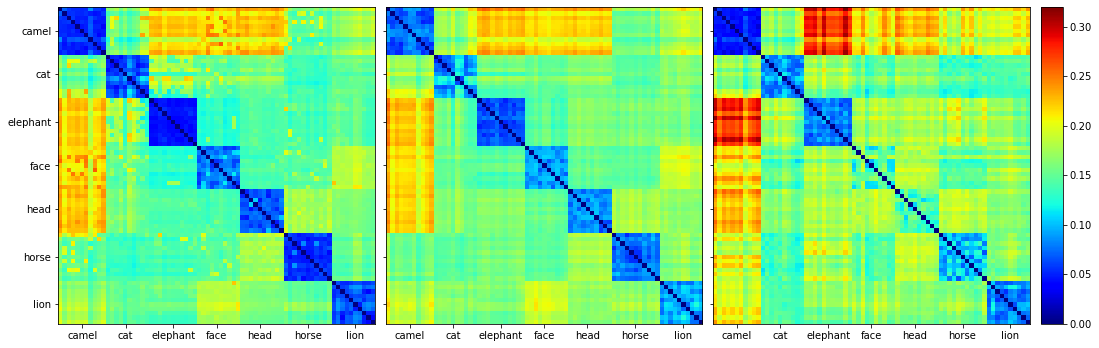

In [9]:
data1 = gw
data2 = lgw1
data3 = lgw2

resultant = [data1,data2,data3]

min_val, max_val = np.amin(resultant), np.amax(resultant)


# Set up figure and image grid
fig = plt.figure(figsize=(18, 6))


grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

plt.setp(grid, xticks=x_ticks, xticklabels=class_names,
        yticks=x_ticks, yticklabels=class_names)

# Add data to image grid
i=0
for ax in grid:
    ax.xaxis.get_label().set_fontsize(20)
    ax.yaxis.get_label().set_fontsize(20)
    #ax_set
    if i == 0:
        im = ax.imshow(gw, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(lgw1, vmin = min_val, vmax = max_val,cmap = "jet")
    else:
        im = ax.imshow(lgw2, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
#matplotlib.colorbar.Colorbar(ax.cax,im)
#ax.cax.cla()
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

# Confusion matrix

In [10]:
def conf_mat(dists,X,y,n_its = 10000):
    N = len(y)
    classes = np.array(np.unique(y),dtype=int)
    x_pred = []
    x_true = []
    for j in range(n_its):
        l = []
        for i in classes:
            l.append([np.random.choice(X[y == i]),i])
        l = np.array(l)
        for i in range(N):
            tmp1 = np.argmin(dists[i][l[:,0]])
            x_true.append(y[i])
            x_pred.append(tmp1)
    
    conf = sklearn.metrics.confusion_matrix(x_true, x_pred)
    return conf

In [11]:
X = np.arange(73)                                                         #dataset
y = np.concatenate([np.ones(lengths[i])*i for i in range(len(lengths))])  #labels

In [12]:
#compute confusion matrices
conf_gw = conf_mat(gw,X=X,y=y) 
conf_lgw1 = conf_mat(lgw1,X=X,y=y)
conf_lgw2 = conf_mat(lgw2,X=X,y=y)

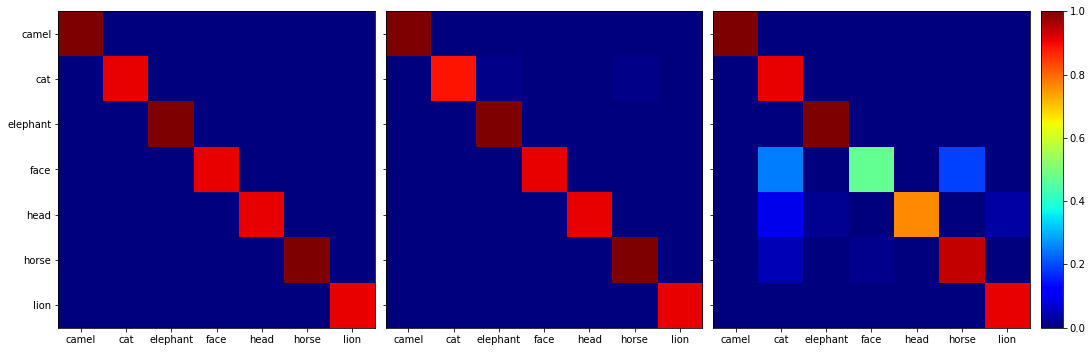

In [13]:
data1 = conf_gw/np.max(conf_gw)
data2 = conf_lgw1/np.max(conf_lgw2)
data3 = conf_lgw2/np.max(conf_lgw2)

resultant = [data1,data2,data3]

min_val, max_val = np.amin(resultant), np.amax(resultant)


# Set up figure and image grid
fig = plt.figure(figsize=(18, 6))


grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(1,3),
                 axes_pad=0.15,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

plt.setp(grid, xticks=range(len(class_names)), xticklabels=class_names,
        yticks=range(len(class_names)), yticklabels=class_names)

# Add data to image grid
i=0
for ax in grid:
    if i == 0:
        im = ax.imshow(data1, vmin = min_val, vmax = max_val,cmap = "jet")
    elif i == 1:
        im = ax.imshow(data2, vmin = min_val, vmax = max_val,cmap = "jet")
    else:
        im = ax.imshow(data3, vmin = min_val, vmax = max_val,cmap = "jet")
    i+=1

# Colorbar
ax.cax.colorbar(im)
#matplotlib.colorbar.Colorbar(ax.cax,im)
#ax.cax.cla()
ax.cax.toggle_label(True)

#plt.tight_layout()    # Works, but may still require rect paramater to keep colorbar labels visible
plt.show()

In [15]:
classes = np.arange(7)

In [17]:
# iterate over k and k_bary
np.random.seed(0)

gamma = 10 #hyperparameter for gw,lgw kernel
coeffs = np.zeros((4,4))
mres = np.zeros((4,4))
accs_gw = []
accs_lgw = np.zeros((4,4))
stds_accs_lgw = np.zeros((4,4))
stds_mres = np.zeros((4,4))
stds_coeffs = np.zeros((4,4))


for p in trange(1,5):
    for q in range(1,5):
        k = 25*p
        k_bary = 25*q

        #load distance matrices and measures
        Ms = []
        heights = []
        for mm in mm_3d_subsamples(k):
            Ms.append(mm[0]/np.max(mm[0]))
            heights.append(mm[1])

        #pairwise gw
        if q == 1:
            gw = np.zeros((N,N))
            #Ps_gw = np.zeros((N,N,k,k))
            st = time.time()
            for i in trange(N):
                for j in range(i+1,N):
                    tmp = ot.gromov.gromov_wasserstein2(Ms[i],Ms[j],heights[i],heights[j],loss_fun="square_loss",log=True)
                    gw[i,j] = tmp[0]
            gw = np.sqrt(gw)
            gw += gw.T
            et = time.time()
            print("GW computation: " + str(np.round(et-st,2)) + " seconds.")

        
        #k_folds
        k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
        k_folds.get_n_splits(X,y)
        
        #K_folds for GW
        if q == 1:
            k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
            k_folds.get_n_splits(X,y)

            accs_gw_per_k = []

            for train_index,test_index in k_folds.split(X,y):
                #get train and test data for this fold
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = y[train_index], y[test_index]

                #set up SVM
                kernel_train = np.exp(-gamma*gw[X_train].T[X_train].T)
                svc = svm.SVC(kernel="precomputed")

                #fit SVM
                clf = svc.fit(kernel_train, y_train)

                kernel_test = np.exp(-gamma*gw[X_test].T[X_train].T)
                acc = clf.score(kernel_test, y_test)
                accs_gw_per_k.append(acc)
            #print("Accuracies: " + str(accs_gw) + ",\nMean accuracy: " + str(np.mean(accs_gw)))
            accs_gw.append(np.mean(accs_gw_per_k))
        accs_lgw_per_k = []
        coeff_per_k = []
        mre_per_k = []
        #k_folds for lgw
        for train_index,test_index in k_folds.split(X,y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            
            #calculate barycenter
            st = time.time()
            idx_bary = [np.random.choice(np.where(y_train == i)[0]) for i in classes]

            n = len(idx_bary)
            height_ref = ot.unif(k_bary)
            M_ref = ot.gromov.gromov_barycenters(k_bary, Cs = np.array(Ms)[idx_bary],
                                                       ps = np.array(heights)[idx_bary], p = height_ref, lambdas = ot.unif(n), loss_fun='square_loss',  # 5e-4,
                                                       max_iter=200, tol=1e-3,random_state=0)
            et = time.time()
            #print("Barycenter computation: " + str(np.round(et-st,2)) + " seconds.")
            
            #S=bary
            lgw,t = lgw_procedure(M_ref,height_ref,None,Ms,heights,mode="graph")
            #print("LGW computation: " + str(np.round(t,2)) + " seconds.")

            #PCC
            coeff_per_k.append(np.corrcoef(gw.flatten(),lgw.flatten())[0,1])

            #MRE
            m_gw = np.ma.masked_equal(gw, 0.0, copy=False)
            m_lgw = np.ma.masked_equal(lgw, 0.0, copy=False)
            mre_per_k.append(np.mean(np.abs(m_gw - m_lgw)/m_gw))
            
            #set up SVM
            kernel_train = np.exp(-gamma*lgw[X_train].T[X_train].T)
            svc = svm.SVC(kernel="precomputed")

            #fit SVM
            clf = svc.fit(kernel_train, y_train)

            kernel_test = np.exp(-gamma*lgw[X_test].T[X_train].T)
            accs_lgw_per_k.append(clf.score(kernel_test, y_test))
        accs_lgw[p-1,q-1] = np.mean(accs_lgw_per_k)
        stds_accs_lgw[p-1,q-1] = np.std(accs_lgw_per_k)
        coeffs[p-1,q-1] = np.mean(coeff_per_k)
        stds_coeffs[p-1,q-1] = np.std(coeff_per_k)
        mres[p-1,q-1] = np.mean(mre_per_k)
        stds_mres[p-1,q-1] = np.std(mre_per_k)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/73 [00:00<?, ?it/s]

GW computation: 5.2 seconds.


  0%|          | 0/73 [00:00<?, ?it/s]

GW computation: 14.83 seconds.


  0%|          | 0/73 [00:00<?, ?it/s]

GW computation: 36.32 seconds.


  0%|          | 0/73 [00:00<?, ?it/s]

GW computation: 75.45 seconds.


In [18]:
print("MRES")
print(np.round(mres,3))
print(np.round(stds_mres,3))

MRES
[[0.234 0.166 0.169 0.175]
 [0.198 0.16  0.149 0.143]
 [0.241 0.188 0.18  0.159]
 [0.242 0.208 0.18  0.164]]
[[0.04  0.012 0.032 0.033]
 [0.023 0.015 0.012 0.015]
 [0.04  0.027 0.03  0.025]
 [0.047 0.026 0.033 0.014]]


In [19]:
print("PCCS")
print(np.round(coeffs,3))
print(np.round(stds_coeffs,3))

PCCS
[[0.758 0.823 0.845 0.828]
 [0.869 0.925 0.927 0.932]
 [0.854 0.906 0.916 0.93 ]
 [0.877 0.908 0.921 0.937]]
[[0.033 0.018 0.026 0.022]
 [0.025 0.014 0.012 0.016]
 [0.042 0.032 0.039 0.023]
 [0.04  0.025 0.04  0.019]]


In [20]:
print("ACCS (GW)")
print(accs_gw)

ACCS (GW)
[1.0, 1.0, 1.0, 1.0]


In [21]:
print("ACCS (LGW)")
print(np.round(accs_lgw,3))
print(np.round(stds_accs_lgw,3))

ACCS (LGW)
[[0.948 1.    0.988 0.971]
 [0.988 0.986 1.    0.986]
 [0.961 1.    1.    0.986]
 [1.    1.    0.986 0.975]]
[[0.064 0.    0.038 0.057]
 [0.038 0.043 0.    0.043]
 [0.06  0.    0.    0.043]
 [0.    0.    0.043 0.05 ]]


In [22]:
# repeat the experiment for camel 10
np.random.seed(0)

mres_c10 = [[],[],[],[]]
pccs_c10 = [[],[],[],[]]
accs_c10 = [[],[],[],[]]

for p in trange(1,5):
    k = 25*p

    #load distance matrices and measures
    Ms = []
    heights = []
    for mm in mm_3d_subsamples(k):
        Ms.append(mm[0]/np.max(mm[0]))
        heights.append(mm[1])
    Ms = np.array(Ms)
    M_C10 = Ms[10]
    height_C10 = heights[10]
    
    #omit camel 10 from data
    Ms = np.concatenate([Ms[:10],Ms[11:]])
    heights = np.concatenate([heights[:10],heights[11:]])
    X_new = np.arange(72)
    y_new = np.concatenate([y[:10],y[11:]])
    
    #pairwise gw
    gw = np.zeros((N-1,N-1))
    #Ps_gw = np.zeros((N,N,k,k))
    st = time.time()
    for i in trange(N-1):
        for j in range(i+1,N-1):
            tmp = ot.gromov.gromov_wasserstein2(Ms[i],Ms[j],heights[i],heights[j],loss_fun="square_loss",log=True)
            gw[i,j] = tmp[0]
    gw = np.sqrt(gw)
    gw += gw.T
    et = time.time()
    print("GW computation: " + str(np.round(et-st,2)) + " seconds.")
    
    #S=camel
    lgw,t = lgw_procedure(M_C10,height_C10,None,Ms,heights,mode="graph")
    print("LGW computation: " + str(np.round(t,2)) + " seconds.")

    #k_folds
    gamma = 10 #hyperparameter for gw,lgw kernel
    k_folds = sklearn.model_selection.StratifiedKFold(n_splits = 10)
    k_folds.get_n_splits(X,y)
    
    #k_folds for lgw
    for train_index,test_index in k_folds.split(X_new,y_new):
        X_train, X_test = X_new[train_index], X_new[test_index]
        y_train, y_test = y_new[train_index], y_new[test_index]
        
        #set up SVM
        kernel_train = np.exp(-gamma*lgw[X_train].T[X_train].T)
        svc = svm.SVC(kernel="precomputed")

        #fit SVM
        clf = svc.fit(kernel_train, y_train)

        #test
        kernel_test = np.exp(-gamma*lgw[X_test].T[X_train].T)
        acc = clf.score(kernel_test, y_test)
        accs_c10[p-1].append(acc)
        
        gw_train = gw[X_train].T[X_train].T
        lgw_train = lgw[X_train].T[X_train].T
        
        #PCC
        pccs_c10[p-1].append(np.corrcoef(gw_train.flatten(),lgw_train.flatten())[0,1])

        #MRE
        m_gw = np.ma.masked_equal(gw_train, 0.0, copy=False)
        m_lgw = np.ma.masked_equal(lgw_train, 0.0, copy=False)
        mres_c10[p-1].append(np.mean(np.abs(m_gw - m_lgw)/m_gw))
        

print("ACCS")
print([np.mean(x) for x in accs_c10])
print([np.std(x) for x in accs_c10])
print("MRES")
print([np.mean(x) for x in mres_c10])
print([np.std(x) for x in mres_c10])
print("PCCS")
print([np.mean(x) for x in pccs_c10])
print([np.std(x) for x in pccs_c10])

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/72 [00:00<?, ?it/s]

GW computation: 5.17 seconds.
LGW computation: 0.27 seconds.


  0%|          | 0/72 [00:00<?, ?it/s]

GW computation: 14.04 seconds.
LGW computation: 0.7 seconds.


  0%|          | 0/72 [00:00<?, ?it/s]

GW computation: 34.85 seconds.
LGW computation: 1.65 seconds.


  0%|          | 0/72 [00:00<?, ?it/s]

GW computation: 75.26 seconds.
LGW computation: 3.02 seconds.
ACCS
[0.9285714285714286, 1.0, 0.9714285714285715, 0.9857142857142858]
[0.095831484749991, 0.0, 0.05714285714285716, 0.04285714285714287]
MRES
[0.2204703723615365, 0.21245665238247108, 0.2179640046983074, 0.2618586897547276]
[0.004696753122494758, 0.0029840622625332135, 0.005125009419993327, 0.0052273488118540065]
PCCS
[0.7300339836987807, 0.842810464544095, 0.851168944770379, 0.8496506839007789]
[0.011314750832592224, 0.003622219767371154, 0.01184693860076229, 0.006245971807210675]
